In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

%matplotlib inline

In [3]:
import librosa
import tensorflow as tf
from tensorflow import keras

2023-10-24 19:13:19.114470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 19:13:19.738225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Data Handeling

## 1.1. CREMA-D

In [4]:
crema_path = os.path.join('data', 'crema-d', 'AudioWAV')

In [5]:
os.path.join(crema_path, os.listdir(crema_path)[0])

'data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav'

In [6]:
files_list = []
emotion_list = []

for pth in os.listdir(crema_path):
    data_path = os.path.join(crema_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[2]
    
    if emot_str == 'HAP':
        emotion_list.append('happy')
    elif emot_str == 'SAD':
        emotion_list.append('sad')
    elif emot_str == 'DIS':
        emotion_list.append('disgust')
    elif emot_str == 'ANG':
        emotion_list.append('anger')
    elif emot_str == 'FEA':
        emotion_list.append('fear')
    elif emot_str == 'NEU':
        emotion_list.append('neutral')
    else:
        emotion_list.append('unknown')

In [7]:
crema_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
crema_df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


## 1.2. RAVDESS

In [8]:
ravdess_path = os.path.join('data', 'ravdess')

In [9]:
os.listdir(os.path.join(ravdess_path, os.listdir(ravdess_path)[0]))[0].split('-')[2]

'02'

(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

In [10]:
files_list = []
emotion_list = []

for actor in os.listdir(ravdess_path):
    actor_data_path = os.path.join(ravdess_path, actor)
    
    for pth in os.listdir(actor_data_path):
        data_path = os.path.join(actor_data_path, pth)
        files_list.append(data_path)
        
        emot_str = pth.split('-')[2]
        
        if emot_str == '01':
            emotion_list.append('neutral')
        elif emot_str == '02':
            emotion_list.append('calm')
        elif emot_str == '03':
            emotion_list.append('happy')
        elif emot_str == '04':
            emotion_list.append('sad')
        elif emot_str == '05':
            emotion_list.append('anger')
        elif emot_str == '06':
            emotion_list.append('fear')
        elif emot_str == '07':
            emotion_list.append('disgust')
        elif emot_str == '08':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [11]:
ravdess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
ravdess_df.head()

,data,emotion
0,data/ravdess/Actor_07/03-01-02-01-01-02-07.wav,calm
1,data/ravdess/Actor_07/03-01-05-01-02-01-07.wav,anger
2,data/ravdess/Actor_07/03-01-02-02-02-02-07.wav,calm
3,data/ravdess/Actor_07/03-01-04-01-02-02-07.wav,sad
4,data/ravdess/Actor_07/03-01-02-02-01-01-07.wav,calm


## 1.3. SAVEE

In [12]:
savee_path = os.path.join('data', 'savee', 'ALL')

('a' = 'anger','d' = 'disgust','f' = 'fear','h' = 'happiness','n' = 'neutral','sa' = 'sadness','su' = 'surprise')

In [13]:
files_list = []
emotion_list = []

for pth in os.listdir(savee_path):
    data_path = os.path.join(savee_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[1][0:-6]
    
    if emot_str == 'h':
        emotion_list.append('happy')
    elif emot_str == 'sa':
        emotion_list.append('sad')
    elif emot_str == 'd':
        emotion_list.append('disgust')
    elif emot_str == 'a':
        emotion_list.append('anger')
    elif emot_str == 'f':
        emotion_list.append('fear')
    elif emot_str == 'n':
        emotion_list.append('neutral')
    elif emot_str == 'su':
        emotion_list.append('surprise')
    else:
        emotion_list.append('unknown')

In [14]:
savee_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
savee_df.head()

,data,emotion
0,data/savee/ALL/KL_h01.wav,happy
1,data/savee/ALL/JE_d13.wav,disgust
2,data/savee/ALL/JE_a04.wav,anger
3,data/savee/ALL/KL_sa04.wav,sad
4,data/savee/ALL/JK_su11.wav,surprise


## 1.4. TESS

In [15]:
tess_path = os.path.join('data', 'tess')

In [16]:
os.listdir(tess_path)[0].split('_')[1]

'disgust'

In [17]:
files_list = []
emotion_list = []

for emotion in os.listdir(tess_path):
    emotion_pth = os.path.join(tess_path, emotion)
    
    for pth in os.listdir(emotion_pth):
        data_path = os.path.join(emotion_pth, pth)
        files_list.append(data_path)
        
        emot_str = emotion.split('_')[1]
        
        if emot_str == 'neutral':
            emotion_list.append('neutral')
        elif emot_str == 'happy':
            emotion_list.append('happy')
        elif emot_str == 'sad':
            emotion_list.append('sad')
        elif emot_str == 'angry':
            emotion_list.append('anger')
        elif emot_str == 'fear':
            emotion_list.append('fear')
        elif emot_str == 'disgust':
            emotion_list.append('disgust')
        elif emot_str == 'surprise':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [18]:
tess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
tess_df.head()

,data,emotion
0,data/tess/OAF_disgust/OAF_gun_disgust.wav,disgust
1,data/tess/OAF_disgust/OAF_red_disgust.wav,disgust
2,data/tess/OAF_disgust/OAF_void_disgust.wav,disgust
3,data/tess/OAF_disgust/OAF_chain_disgust.wav,disgust
4,data/tess/OAF_disgust/OAF_yes_disgust.wav,disgust


## 1.5. Compilation

In [19]:
df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


In [20]:
df = df.sample(frac = 1)
df.head()

,data,emotion
256,data/crema-d/AudioWAV/1062_ITH_FEA_XX.wav,fear
2324,data/crema-d/AudioWAV/1058_MTI_FEA_XX.wav,fear
1557,data/crema-d/AudioWAV/1024_WSI_FEA_XX.wav,fear
27,data/tess/OAF_disgust/OAF_ripe_disgust.wav,disgust
547,data/tess/OAF_neutral/OAF_pain_neutral.wav,neutral


In [21]:
df_path = os.path.join('data', "data.csv")

In [22]:
# df.to_csv(df_path, index=False)

## 1.6. Data Loading

In [23]:
df_path = os.path.join('data', "data.csv")

In [24]:
df = pd.read_csv(df_path)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1037_ITS_ANG_XX.wav,anger
1,data/crema-d/AudioWAV/1072_TIE_SAD_XX.wav,sad
2,data/crema-d/AudioWAV/1055_TSI_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1067_IWW_DIS_XX.wav,disgust
4,data/crema-d/AudioWAV/1012_MTI_DIS_XX.wav,disgust


In [25]:
df.emotion.unique()

array(['anger', 'sad', 'disgust', 'neutral', 'happy', 'fear'],
      dtype=object)

In [26]:
df.isnull().sum()

data       0
emotion    0
dtype: int64

In [27]:
df.emotion.value_counts()

emotion
anger      1923
sad        1923
disgust    1923
happy      1923
fear       1923
neutral    1703
Name: count, dtype: int64

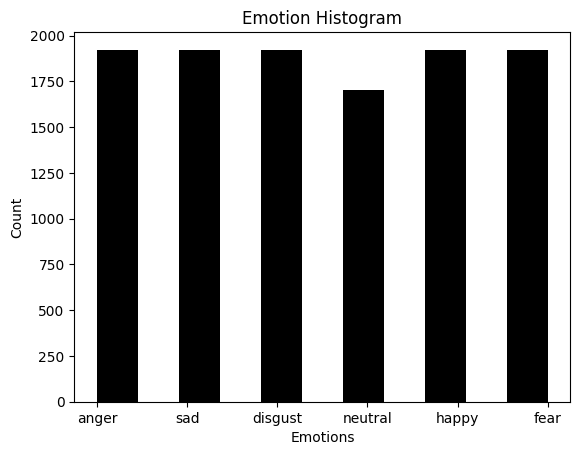

In [28]:
plt.title('Emotion Histogram')
plt.hist(df.emotion, color='black', bins=11)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

# 2. Data Processing

## 2.1. Data Augmentation

In [29]:
np.array(df.data)[50]

'data/savee/ALL/KL_n01.wav'

In [30]:
path = np.array(df.data)[50]
data_sample, sample_rate = librosa.load(path)
np.array(df.emotion)[50]

'neutral'

In [31]:
Audio(path)

In [32]:
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise

def augmentation(audio):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-1, max_semitones=1),
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005),
    ])
    
    augmented_audio = augment(samples=audio, sample_rate=sample_rate)
    return augmented_audio

In [33]:
x = augmentation(data_sample)
print(np.array(df.emotion)[50])
Audio(x, rate=sample_rate)

neutral


## 2.2. Feature Extraction

In [34]:
def extract_features(audio_data, sample_rate):    
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    rmse = librosa.feature.rms(y=audio_data)
    
    mean = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
    std = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)
    skewness = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    kurtosis = librosa.feature.poly_features(y=audio_data, sr=sample_rate)
    
    ans = np.concatenate((mfccs, chroma, spectral_centroid, zcr, rmse, mean, std, skewness, kurtosis), axis=0)
    
    return ans.T

In [35]:
extract_features(data_sample, sample_rate).shape

(155, 66)

- Row : Timeframe
- Column : Features

In [36]:
df.shape[0]

11318

## 2.3. Data Processing

In [37]:
def data_processing(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.5)
    
    result = []
    for i in range(5):
        augmented_data = augmentation(data)
        features = extract_features(augmented_data, sample_rate)
        result.append(features)
    
    return np.array(result)

In [39]:
data_processing(df.iloc[1011, 0])[0].shape

(52, 66)

In [42]:
def create_features_file():
    i = 0
    end = len(df)
    feature_path = os.path.join('data', 'feature')
    
    split_path = ''

    while i < end:
        features = data_processing(df.iloc[i, 0])        
        j = 0
        for feature in features:
            file_name = 'np_' + str(i) + '_' + str(j) + '_' + df.iloc[i, 1] + '.npy'
            
            if i < len(df) * 0.6:
                split_path = 'train'
            elif i < len(df) * 0.8:
                split_path = 'val'
            else:
                split_path = 'test'

            feature_save_path = os.path.join(feature_path, split_path, file_name)
            np.save(feature_save_path, feature)
            j += 1
            
        i += 1
        print(i, '/', end, '-> DONE')

In [ ]:
create_features_file()

# 3. Dataset

In [ ]:
feature_dir = os.path.join('data', 'feature')

i = 0
for x in os.listdir(os.path.join(feature_dir, 'train')):
    print(x.split('_')[-1][0:-4])
    
    if i > 5:
        break
    i += 1

In [ ]:
emotion_class = {'fear' : 0,
                 'anger' : 1,
                 'happy' : 2,
                 'disgust' : 3,
                 'sad' : 4,
                 'neutral' : 5
                }

In [ ]:
def get_generator(pth_str, n_rows):
    curr_dir = os.path.join(feature_dir, pth_str)
    
    def generator():
        for npy_file in os.listdir(curr_dir):
            npy_pth = os.path.join(curr_dir, npy_file)

            label = npy_file.split('_')[-1][0:-4]

            data = np.load(npy_pth)
            data = np.pad(data, ((0, n_rows - data.shape[0]), (0, 0)), 'constant', constant_values=0)

            yield data, emotion_class[label]
    
    return generator

In [ ]:
train_generator = get_generator('train', 110)
val_generator = get_generator('val', 110)
test_generator = get_generator('test', 110)

train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_rows, 66), ())
)
val_ds = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_rows, 66), ())
)
test_ds = tf.data.Dataset.from_generator(
    test_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_rows, 66), ())
)

In [ ]:
for file in train_ds.take(1):
    print(file)

In [ ]:
# def reshape_data(datapoint, label):
#     reshaped_data = tf.expand_dims(datapoint, axis=-1)
    
#     return (reshaped_data, label)

In [ ]:
# numpy_dataset = numpy_dataset.map(reshape_data)

# for file in numpy_dataset.take(3):
#     print(file)

## 3.1. One Hot Encoding

In [ ]:
def one_hot_encoding(datapoint, label):
    num_classes = len(emotion_class)

    one_hot_label = tf.one_hot(label, depth=num_classes)
    
    return (datapoint, one_hot_label)

In [ ]:
train_ds = train_ds.map(one_hot_encoding)
val_ds = val_ds.map(one_hot_encoding)
test_ds = test_ds.map(one_hot_encoding)

for file in train_ds.take(3):
    print(file)

In [ ]:
batch_size = 32

In [ ]:
train_ds = train_ds.batch(batch_size).shuffle(12).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()

In [ ]:
for x in val_ds.take(2):
    print(x)

In [ ]:
def make_model():
    input_layer = tf.keras.layers.Input(shape = (110, 66))
    lstm_1 = tf.keras.layers.LSTM(64)(input_layer)
    hidden1 = tf.keras.layers.Dense(64, activation='relu')(lstm_1)
    hidden2 = tf.keras.layers.Dense(32, activation='relu')(hidden1)
    output = tf.keras.layers.Dense(6, activation='softmax')(hidden2)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
model = make_model()

model.summary()

In [ ]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [ ]:
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

In [ ]:
model.evaluate(train_ds, verbose=1)

In [ ]:
val_ds.element_spec[0]

In [ ]:
hist = model.fit(train_ds, epochs=50, verbose=2, validation_data=val_ds, callbacks=[early_stopping])